In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("daily_logs.csv")
df.head()

,todoId,userId,date,minutes,estimatedMinutes,deadlineDate,createdDate,text
0,15o0rm4pJCgfVjP6jpy1,DgApBqtxpeVE5G5MnIVw9ThpyN93,2025-12-18,5,250,2026-03-20,2025-12-18,タイピング練習
1,15o0rm4pJCgfVjP6jpy1,DgApBqtxpeVE5G5MnIVw9ThpyN93,2025-12-19,10,250,2026-03-20,2025-12-18,タイピング練習
2,1fQSP4olWNYjyj9ztsIa,qEvovKzp9yTvyfV3IGR9OUERHbk1,2025-12-02,30,30,2025-12-24,2025-12-02,研究
3,53EIH4uY2PeAUhQgrVkk,DgApBqtxpeVE5G5MnIVw9ThpyN93,2025-10-16,20,240,2025-10-21,2025-10-20,中間発表の資料を完成させる
4,53EIH4uY2PeAUhQgrVkk,DgApBqtxpeVE5G5MnIVw9ThpyN93,2025-10-18,30,240,2025-10-21,2025-10-20,中間発表の資料を完成させる


In [2]:
d = df.copy()

d["date"] = pd.to_datetime(d["date"], errors="coerce").dt.date
d["deadlineDate"] = pd.to_datetime(d["deadlineDate"], errors="coerce").dt.date

d["minutes"] = pd.to_numeric(d["minutes"], errors="coerce").fillna(0.0)
d["estimatedMinutes"] = pd.to_numeric(d["estimatedMinutes"], errors="coerce")

d = d.dropna(subset=["todoId", "date", "estimatedMinutes", "deadlineDate"])

daily = (d.groupby(["todoId", "date"], as_index=False)
           .agg(
               minutes=("minutes", "sum"),
               estimatedMinutes=("estimatedMinutes", "max"),
               deadlineDate=("deadlineDate", "max"),
               text=("text", "last"),
               userId=("userId", "last"),
           ))

daily = daily.rename(columns={"todoId":"taskId", "deadlineDate":"dueDate", "estimatedMinutes":"estimateMinutes"})
daily.head()


,taskId,date,minutes,estimateMinutes,dueDate,text,userId
0,15o0rm4pJCgfVjP6jpy1,2025-12-18,5,250,2026-03-20,タイピング練習,DgApBqtxpeVE5G5MnIVw9ThpyN93
1,15o0rm4pJCgfVjP6jpy1,2025-12-19,10,250,2026-03-20,タイピング練習,DgApBqtxpeVE5G5MnIVw9ThpyN93
2,1fQSP4olWNYjyj9ztsIa,2025-12-02,30,30,2025-12-24,研究,qEvovKzp9yTvyfV3IGR9OUERHbk1
3,53EIH4uY2PeAUhQgrVkk,2025-10-16,20,240,2025-10-21,中間発表の資料を完成させる,DgApBqtxpeVE5G5MnIVw9ThpyN93
4,53EIH4uY2PeAUhQgrVkk,2025-10-18,30,240,2025-10-21,中間発表の資料を完成させる,DgApBqtxpeVE5G5MnIVw9ThpyN93


In [3]:
def rolling_mean_last_n(arr, n=7):
    out = np.full(len(arr), np.nan, dtype=float)
    for i in range(len(arr)):
        start = max(0, i-n+1)
        out[i] = np.mean(arr[start:i+1])
    return out

rows = []
for taskId, g in daily.sort_values(["taskId","date"]).groupby("taskId"):
    g = g.sort_values("date").reset_index(drop=True)

    minutes = g["minutes"].to_numpy(dtype=float)
    est = float(g["estimateMinutes"].iloc[0])
    due = g["dueDate"].iloc[0]

    # 累積（after は当日含む、before は当日除外）
    cum_after = np.cumsum(minutes)
    cum_before = np.concatenate([[0.0], cum_after[:-1]])

    # 当日朝時点の残量
    remaining = np.maximum(0.0, est - cum_before)

    # 残日数（当日を含む。0割回避で最低1）
    days_left = np.array([(due - dt).days for dt in g["date"]], dtype=float)
    days_left = np.maximum(1.0, days_left)

    required = remaining / days_left

    # pace7d_after：当日含む
    pace_after = rolling_mean_last_n(minutes, n=7)

    # pace7d_before：当日含めない（= i-1までの平均）
    pace_before = np.full(len(minutes), np.nan, dtype=float)
    for i in range(len(minutes)):
        j_end = i - 1
        if j_end < 0:
            pace_before[i] = np.nan
        else:
            j_start = max(0, j_end-7+1)
            pace_before[i] = np.mean(minutes[j_start:j_end+1])

    spi_before = pace_before / required
    spi_after  = pace_after  / required

    out = g.copy()
    out["cum_before"] = cum_before
    out["cum_after"] = cum_after
    out["remaining_before"] = remaining
    out["daysLeft"] = days_left
    out["required"] = required
    out["pace7d_before"] = pace_before
    out["pace7d_after"]  = pace_after
    out["SPI_before"] = spi_before
    out["SPI_after"]  = spi_after
    out["dSPI"] = out["SPI_after"] - out["SPI_before"]
    rows.append(out)

calc = pd.concat(rows, ignore_index=True)
calc[["taskId","date","minutes","SPI_before","SPI_after","dSPI"]].head(20)


/tmp/ipython-input-3093547718.py:42: RuntimeWarning: divide by zero encountered in divide
  spi_before = pace_before / required
/tmp/ipython-input-3093547718.py:43: RuntimeWarning: divide by zero encountered in divide
  spi_after  = pace_after  / required
/tmp/ipython-input-3093547718.py:42: RuntimeWarning: divide by zero encountered in divide
  spi_before = pace_before / required
/tmp/ipython-input-3093547718.py:43: RuntimeWarning: divide by zero encountered in divide
  spi_after  = pace_after  / required


,taskId,date,minutes,SPI_before,SPI_after,dSPI
0,15o0rm4pJCgfVjP6jpy1,2025-12-18,5,NaN,1.840000,NaN
1,15o0rm4pJCgfVjP6jpy1,2025-12-19,10,1.857143,2.785714,0.928571
2,1fQSP4olWNYjyj9ztsIa,2025-12-02,30,NaN,22.000000,NaN
3,53EIH4uY2PeAUhQgrVkk,2025-10-16,20,NaN,0.416667,NaN
4,53EIH4uY2PeAUhQgrVkk,2025-10-18,30,0.272727,0.340909,0.068182
5,53EIH4uY2PeAUhQgrVkk,2025-10-19,90,0.263158,0.491228,0.228070
6,53EIH4uY2PeAUhQgrVkk,2025-10-20,120,0.466667,0.650000,0.183333
7,5KxoVTiwYbl1q6tepu0D,2025-11-12,70,NaN,0.777778,NaN
8,5KxoVTiwYbl1q6tepu0D,2025-11-17,20,3.500000,2.250000,-1.250000
9,5NHkI2KZn1oWspLbrLVE,2025-10-21,60,NaN,1.000000,NaN


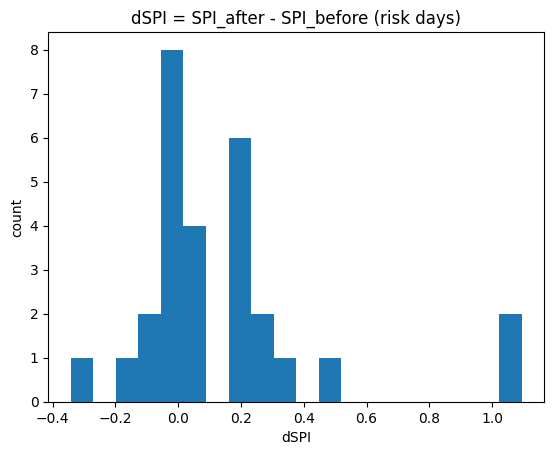

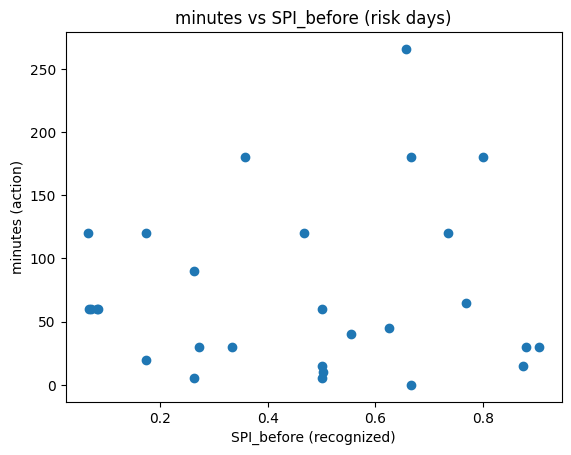

risk days: 28
count    28.000000
mean      0.142935
std       0.314969
min      -0.342412
25%      -0.005109
50%       0.045996
75%       0.221080
max       1.093750
Name: dSPI, dtype: float64


In [4]:
def classify_spi(x):
    if pd.isna(x): return "na"
    if x >= 1.0: return "ontrack"
    if x >= 0.8: return "warning"
    return "delay"

calc["state_before"] = calc["SPI_before"].apply(classify_spi)
calc["is_risk_before"] = calc["state_before"].isin(["warning","delay"])

risk = calc[calc["is_risk_before"] & calc["dSPI"].notna()].copy()

plt.figure()
plt.hist(risk["dSPI"], bins=20)
plt.title("dSPI = SPI_after - SPI_before (risk days)")
plt.xlabel("dSPI")
plt.ylabel("count")
plt.show()

plt.figure()
plt.scatter(risk["SPI_before"], risk["minutes"])
plt.title("minutes vs SPI_before (risk days)")
plt.xlabel("SPI_before (recognized)")
plt.ylabel("minutes (action)")
plt.show()

print("risk days:", len(risk))
print(risk["dSPI"].describe())
